# Importamos librería

In [3]:
import pandas as pd
import chart_studio.plotly as py
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import cufflinks as cf
from datetime import datetime
from ipywidgets import interact
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import warnings
import cartopy
warnings.filterwarnings('ignore')
import plotly.offline as off
import json
import requests
from pandas.io.json import json_normalize
import re
cf.go_offline()

# Importar datos

In [120]:
url='https://api.covid19api.com/all'

response = requests.get(url, headers={"user-agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36"})
result=response.json()
result

[{'Country': 'Thailand',
  'Province': '',
  'Lat': 15,
  'Lon': 101,
  'Date': '2020-01-22T00:00:00Z',
  'Cases': 2,
  'Status': 'confirmed'},
 {'Country': 'Thailand',
  'Province': '',
  'Lat': 15,
  'Lon': 101,
  'Date': '2020-01-23T00:00:00Z',
  'Cases': 3,
  'Status': 'confirmed'},
 {'Country': 'Thailand',
  'Province': '',
  'Lat': 15,
  'Lon': 101,
  'Date': '2020-01-24T00:00:00Z',
  'Cases': 5,
  'Status': 'confirmed'},
 {'Country': 'Thailand',
  'Province': '',
  'Lat': 15,
  'Lon': 101,
  'Date': '2020-01-25T00:00:00Z',
  'Cases': 7,
  'Status': 'confirmed'},
 {'Country': 'Thailand',
  'Province': '',
  'Lat': 15,
  'Lon': 101,
  'Date': '2020-01-26T00:00:00Z',
  'Cases': 8,
  'Status': 'confirmed'},
 {'Country': 'Thailand',
  'Province': '',
  'Lat': 15,
  'Lon': 101,
  'Date': '2020-01-27T00:00:00Z',
  'Cases': 8,
  'Status': 'confirmed'},
 {'Country': 'Thailand',
  'Province': '',
  'Lat': 15,
  'Lon': 101,
  'Date': '2020-01-28T00:00:00Z',
  'Cases': 14,
  'Status': 'conf

In [121]:
df_coronavirus_raw = pd.DataFrame()
df_coronavirus_raw = json_normalize(result)
df_coronavirus_raw.head()

,Country,Province,Lat,Lon,Date,Cases,Status
0,Thailand,,15.0,101.0,2020-01-22T00:00:00Z,2,confirmed
1,Thailand,,15.0,101.0,2020-01-23T00:00:00Z,3,confirmed
2,Thailand,,15.0,101.0,2020-01-24T00:00:00Z,5,confirmed
3,Thailand,,15.0,101.0,2020-01-25T00:00:00Z,7,confirmed
4,Thailand,,15.0,101.0,2020-01-26T00:00:00Z,8,confirmed


# Data cleaning

## Renombramos columnas y estandarizamos nombres

In [122]:
df_coronavirus_raw.columns = df_coronavirus_raw.columns.str.replace('[.]','_').str.lower()
df_coronavirus_raw = df_coronavirus_raw.rename(columns = {'lat':'latitude', 'lon':'longitude'})
df_coronavirus_raw.head()

,country,province,latitude,longitude,date,cases,status
0,Thailand,,15.0,101.0,2020-01-22T00:00:00Z,2,confirmed
1,Thailand,,15.0,101.0,2020-01-23T00:00:00Z,3,confirmed
2,Thailand,,15.0,101.0,2020-01-24T00:00:00Z,5,confirmed
3,Thailand,,15.0,101.0,2020-01-25T00:00:00Z,7,confirmed
4,Thailand,,15.0,101.0,2020-01-26T00:00:00Z,8,confirmed


## Clasificamos los paises entre China y resto del mundo
## Calculamos los casos existentes = Casos confirmados - fallecidos - recuperados

In [123]:
df_coronavirus_raw['class'] = np.where(df_coronavirus_raw.country.str.contains('China'), 'China', 'Other Countries')
df_coronavirus_raw['date'] = pd.to_datetime(df_coronavirus_raw['date'], format="%Y-%m-%dT%H:%M:%SZ")
l_index = ['class','country', 'province', 'latitude','longitude', 'date']
df_coronavirus = pd.pivot_table(df_coronavirus_raw, values='cases', 
                index = l_index, columns=['status'],
                aggfunc=np.sum, fill_value=0).reset_index()
df_coronavirus['existing'] = df_coronavirus.confirmed.fillna(0) -  df_coronavirus.deaths.fillna(0) - df_coronavirus.recovered.fillna(0)
df_coronavirus.head()

status,class,country,province,latitude,longitude,date,confirmed,deaths,recovered,existing
0,China,China,Anhui,31.8257,117.226,2020-01-22,1,0,0,1
1,China,China,Anhui,31.8257,117.226,2020-01-23,9,0,0,9
2,China,China,Anhui,31.8257,117.226,2020-01-24,15,0,0,15
3,China,China,Anhui,31.8257,117.226,2020-01-25,39,0,0,39
4,China,China,Anhui,31.8257,117.226,2020-01-26,60,0,0,60


## Ordenamos columas

In [124]:
column_order = ['date', 'class', 'country', 'province', 'latitude', 'longitude', \
                'confirmed','deaths', 'recovered', 'existing']
df_coronavirus = df_coronavirus[column_order]
df_coronavirus.head()

status,date,class,country,province,latitude,longitude,confirmed,deaths,recovered,existing
0,2020-01-22,China,China,Anhui,31.8257,117.226,1,0,0,1
1,2020-01-23,China,China,Anhui,31.8257,117.226,9,0,0,9
2,2020-01-24,China,China,Anhui,31.8257,117.226,15,0,0,15
3,2020-01-25,China,China,Anhui,31.8257,117.226,39,0,0,39
4,2020-01-26,China,China,Anhui,31.8257,117.226,60,0,0,60


# Scatterplot Evolución de Casos de china vs. el resto del mundo

## Obtenemos la suma acumulada de casos por el tipo de gráfico

In [125]:
col_vars = ['confirmed','deaths', 'recovered', 'existing']
cat_vars = list(df_coronavirus['class'].unique())
df_china_row = df_coronavirus.groupby(['class','date'])[col_vars].agg('sum').reset_index()

## Diagramamos el scatterplot

In [126]:
fig = make_subplots(rows=1, cols=len(cat_vars), shared_yaxes=True, subplot_titles=('China','Resto del Mundo'))
for c in range(0,len(cat_vars)):
    for x in range(0,len(col_vars)):º
        fig.add_trace(go.Scatter( \
                      x = df_china_row[df_china_row['class']==cat_vars[c]]['date'], \
                      y = df_china_row[df_china_row['class']==cat_vars[c]][col_vars[x]], \
                      mode = 'lines+markers',
                      name = f'{cat_vars[c]} - {col_vars[x].capitalize()}'),
                      row=1, col=c+1)

fig.update_layout(height=500, width=1000, title_text="Evolución de casos China vs. Resto del mundo")
fig.show()

**Insights**: 
* Se puede ver un comportamiento distinto entre China y el resto del mundo, por lo que se han dividido las gráficas en estos dos grupos.
  * China: Un aumento muy claro de casos desde el inicio de la enfermedad hasta el 14 de febrero (con picos el 12, 13 y 14 de Febrero). A partir de allí las medidas tomadas por el gobierno de China comienzan a dar resutados y el número de casos que se recuperan sube exponencialmente. Asimismo los casos confirmados bajan diariamente lo que indica la remisión del virus. Sin embargo el virus ha dejado 3193 muetros en el territorio de China.
  * Resto del mundo: A partir del 14 de Febrero los casos en los demás paises comienzan a crecer exponencialmente. A partir del 10 de Marzo se dan crecimientos más altos que los días de crecimiento más altos de la enfermedad en China, por lo que se declara el grado de pandemia. Se puede ser además que si no se toman las medidas de contención necesarias y se sigue la misma curva de progresión de la enfermedad que en China (en el mejor de los casos) la enfermedad puede llegar a duplicar el número de casos confirmados en el mundo.

# Histograma: Suma acumulada de casos de coronavirus por país

##  Sumarizamos los casos para obtener los acumulados por país y por fecha

In [127]:
col_vars = ['confirmed','deaths', 'recovered', 'existing']
cou_vars = ['All']
cou_vars.extend(sorted(list(df_coronavirus['country'].unique())))

df_countries = df_coronavirus.groupby(['country','date'])[col_vars].agg('sum').reset_index()

## Creamos un combobox con los países y diagramamos los casos confirmados, muertos, recuperados y existentes

In [128]:
def make_hist(Country): 
    nrows = 2
    ncols = nrows
    fig = make_subplots(rows = nrows, cols = ncols, subplot_titles=[f'Total of {c} cases' for c in col_vars])
    for c in range(0,len(col_vars)):
        if(Country=='All'):
            df_filtered = df_countries
        else:
            df_filtered = df_countries[df_countries['country']==Country]
        fig.add_trace(
            go.Bar(x = df_filtered['date'], \
                y = df_filtered[col_vars[c]], \
                name = col_vars[c].capitalize()),
                row=int(c/nrows)+1, col=(c%ncols)+1)
    fig.update_layout(height=1000, width=1000, title_text="Casos acumulados de coronavirus por país")
    fig.show()

_= interact(make_hist, Country = (cou_vars))

interactive(children=(Dropdown(description='Country', options=('All', 'Afghanistan', 'Albania', 'Algeria', 'An…

**Insights**: 
* Si seleccionamos la opción All, se puede ver el la composición de casos por país, donde hasta hace unos días el protagonista era China. A partir del 14 de Febrero la actividad del virus remite en China, pero se contafia al resto del mundo. Adicionalmente se puede ser que el ratio de muerte de la enfermedad es muy bajo.
* En España e Italia los casos han crecido exponencialmente desde Marzo.

# Plotbar: Top 10 de los países más afectados por el coronavirus: España entra con todo al último momento

In [132]:
df_countries_top10 = df_countries.groupby('date',group_keys=False)\
            .apply(lambda grp:grp.nlargest(n=int(10),columns='confirmed').sort_index()).reset_index()

In [117]:
df_countries_top10 = df_countries.groupby('date',group_keys=False)\
            .apply(lambda grp:grp.nlargest(n=int(10),columns='confirmed').sort_index()).reset_index()
# df_countries_top10.head()
fig =px.bar(df_countries_top10, x='confirmed', y='country',  
             labels={'confirmed': f'Confirmed cases by country',
                    'country':'Top 10 countries with confirmed cases'},
             animation_frame=df_countries_top10.date.dt.strftime('%Y-%m-%d'), orientation='h').update_yaxes(categoryorder='total ascending')
fig.update_layout(title_text="Evolution of confirmed cases by country: Top 10")
fig.show()

**Insights:**

En esta progresión de tiempo se puede ver el crecimiento de la expansión de virus en europa especialmente en Italia y España en Europa e Iran y Corea del Sur en el mes de Marzo. Antes de ello la cantidad de casos de concentraba en China.

# Boxplot: Casos confirmados de coronavirus: Estadísticas

In [130]:
df_countries_top10 = df_countries.groupby('date',group_keys=False)\
            .apply(lambda grp:grp.nlargest(n=int(10),columns='confirmed').sort_index()).reset_index()
df_countries_top10.head()

status,index,country,date,confirmed,deaths,recovered,existing
0,0,Afghanistan,2020-01-22,0,0,0,0
1,53,Albania,2020-01-22,0,0,0,0
2,106,Algeria,2020-01-22,0,0,0,0
3,159,Andorra,2020-01-22,0,0,0,0
4,1431,China,2020-01-22,548,17,28,503


In [131]:
fig = px.box(df_china_row, y="confirmed", x='class', 
             labels={'confirmed': f'Confirmed cases of Coronavirus',
            'class':'Agrupation by countries: China vs. Rest of the world'},
             points="all")
fig.update_layout(title_text="Stats of confirmed cases: China vs. Rest of world")
fig.show()

**Insights:**

En este gráfico no se puede sacar muchos insights ya que la curva de tiempo de la evolución del virus en China está en un estado de descenso, mientras que en el resto del mundo está ascendiendo. Lo que sí se puede ver es que la gravedad de los casos en el mundo ya está superando a China y se deben estudiar en los próximos días la evolución en los países más afectados de forma separada. 

# Bonus track: Geoplot: Casos informados de coronavirus por países

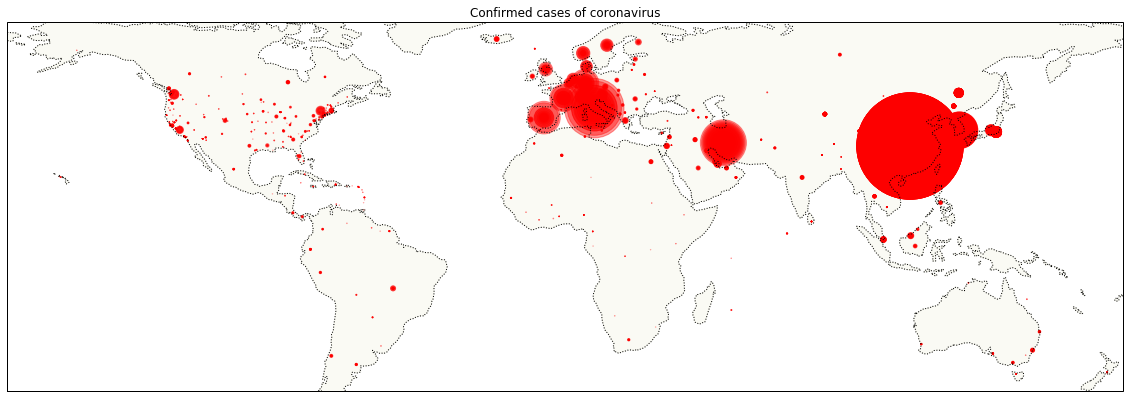

In [133]:
plt.figure(figsize=(20,20))
ax = plt.axes(projection=cartopy.crs.PlateCarree())

ax.add_feature(cartopy.feature.LAND, alpha=0.3 )
ax.add_feature(cartopy.feature.COASTLINE, linestyle=':')

plt.scatter(df_coronavirus['longitude'], df_coronavirus['latitude'], s=df_coronavirus['confirmed']/6, alpha=0.4, c='r')
plt.title('Confirmed cases of coronavirus')
plt.show()

**Insights:**

Hace un par de meses Chinaera el protagonista mundial de este gráfic, sin embargo el panorama actual es distinto, ya que el virus se ha diseminado por toda Europa.